In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib
%matplotlib inline

In [2]:
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
from scipy.stats import norm
import time

In [3]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score,precision_recall_curve, roc_auc_score, accuracy_score,average_precision_score, classification_report, roc_curve
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold,StratifiedShuffleSplit,cross_val_score,GridSearchCV,ShuffleSplit,learning_curve,cross_val_predict
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [4]:
def load_training(n_fp=1e4):
    df = pd.read_csv("../RESULTS/chonk.trainingset.somatic.giabchr19.combined.filtered.germlinegt.20190901.txt",sep="\t")
    feats = list(df.columns)[6:20]+list(df.columns)[23:27]
    df[feats] = df[feats].fillna(0)
    tp_df = df.loc[(df['lab']==1) & (df['af']<0.5) ]
    fp_df = df.loc[df['lab']==0][:int(n_fp)]
    df = pd.concat([tp_df,fp_df]).sample(frac=1,random_state=42)
    return df,feats
def report_class_counts(df):
    print('Somatic', round(df['lab'].value_counts()[0]/len(df) * 100,4), '% of data')
    print('False Positive', round(df['lab'].value_counts()[1]/len(df) * 100,4), '% of data')
    print('Somatic:', df['lab'].value_counts()[1])
    print('False Positive:', df['lab'].value_counts()[0])
#Random Under-Sampling
def random_undersample(df):
    df = df.sample(frac=1,random_state=42) #shuffle
    tp_df = df.loc[df['lab'] == 1]
    fp_df = df.loc[df['lab'] == 0][:len(tp_df)]
    return pd.concat([tp_df, fp_df]).sample(frac=1,random_state=42)

18


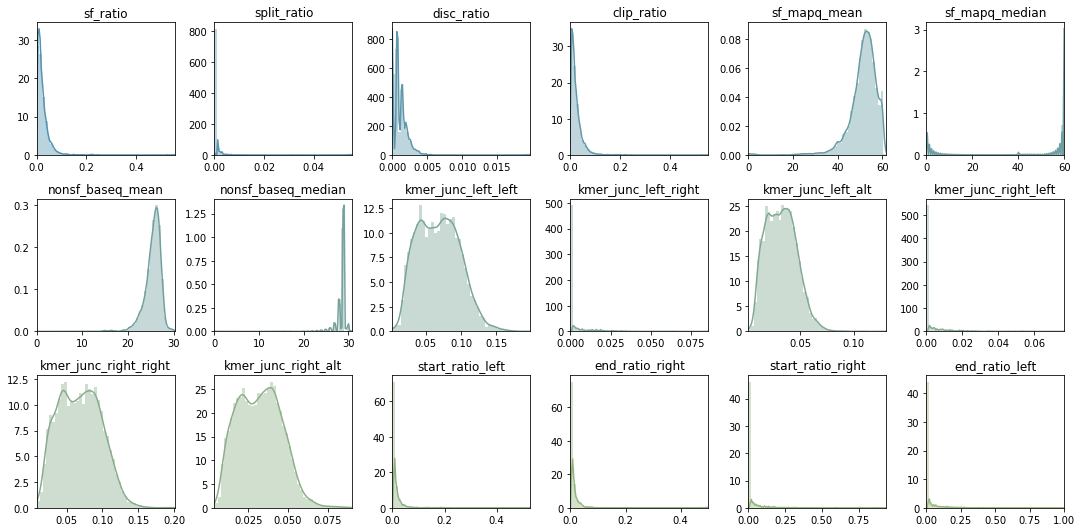

In [5]:
df, feats = load_training()
print(len(feats))
nrows=3
ncols=6
sz=2.5
clr = ['#5293b1', '#5895ae', '#5e97ab', '#6399a8', '#689ca4', '#6d9ea1', '#71a09e', '#76a29b', '#7aa498', '#7da695', '#81a892', '#85aa8e', '#88ac8b', '#8caf88', '#8fb184', '#92b381', '#95b57d', '#98b77a']
f, ax = plt.subplots(nrows,ncols,figsize=(sz*ncols,sz*nrows))

for ft, a,c in zip(feats,ax.flatten(),clr):
    sns.distplot(df[ft].values,ax=a,color=c)
    a.set_title(ft)
    a.set_xlim([min(df[ft].values),max(df[ft].values)])

f.tight_layout()
f.savefig("../FIGURES/som.train.feats.png",dpi=500)
f.savefig("../FIGURES/som.train.feats.svg",dpi=500)


In [6]:
# spliting the data
df, feats = load_training()
X = df[feats]
y = df['lab']
sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values
df_test = df.iloc[test_index]
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)
print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 1259  1634  1726 ... 10065 10066 10067] Test: [   0    1    2 ... 2018 2019 2020]
Train: [    0     1     2 ... 10065 10066 10067] Test: [1259 1634 1726 ... 4031 4032 4033]
Train: [    0     1     2 ... 10065 10066 10067] Test: [2810 2824 3018 ... 6042 6043 6044]
Train: [    0     1     2 ... 10065 10066 10067] Test: [5699 5902 5968 ... 8053 8054 8055]
Train: [   0    1    2 ... 8053 8054 8055] Test: [ 8028  8056  8057 ... 10065 10066 10067]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99317194 0.00682806]
[0.99354198 0.00645802]


In [7]:
df,feats = load_training()
report_class_counts(df)
new_df = random_undersample(df)
report_class_counts(new_df)

Somatic 99.3246 % of data
False Positive 0.6754 % of data
Somatic: 68
False Positive: 10000
Somatic 50.0 % of data
False Positive 50.0 % of data
Somatic: 68
False Positive: 68


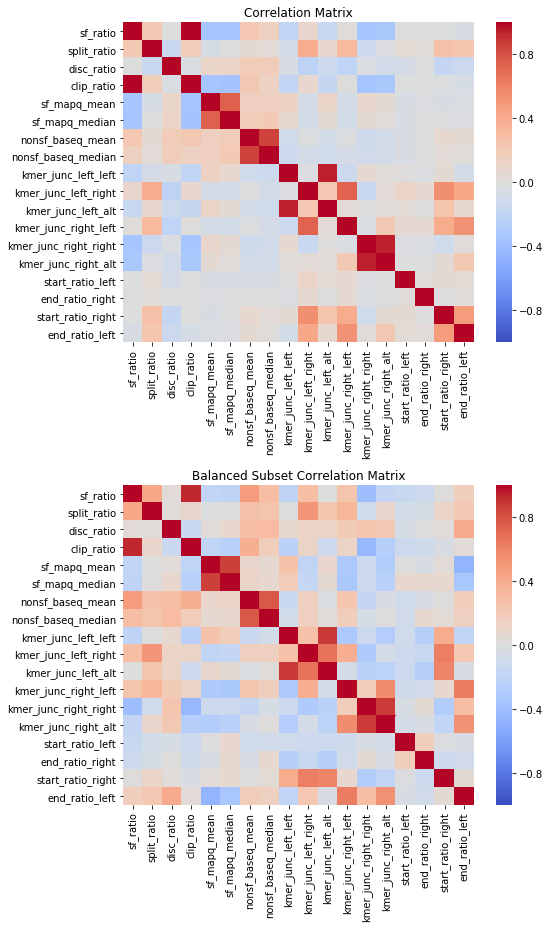

In [8]:
#correlation matrices
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,13))

# Entire DataFrame
corr = df[feats].corr()
sns.heatmap(corr, 
            cmap='coolwarm', 
            #annot_kws={'size':20}, 
            ax=ax1,
            vmin=-1,vmax=1,
           )
ax1.set_title("Correlation Matrix")
sub_sample_corr = new_df[feats].corr()
sns.heatmap(sub_sample_corr, 
            cmap='coolwarm', 
            #annot_kws={'size':20}, 
            ax=ax2,
            vmin=-1,vmax=1,
           )
ax2.set_title('Balanced Subset Correlation Matrix')
f.tight_layout()
f.savefig("../FIGURES/som.train.corrmat.png",dpi=500)
f.savefig("../FIGURES/som.train.corrmat.svg",dpi=500)

4
4


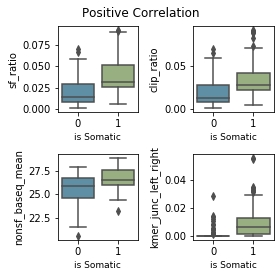

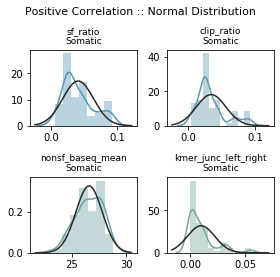

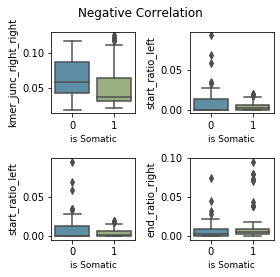

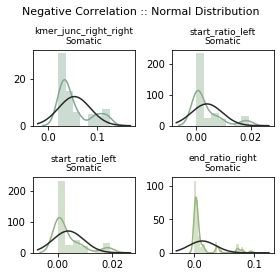

In [9]:
def plot_pos_neg_corr(df):
    colr = ['#5293b1','#98b77a']
    pc = ['#5293b1', '#6098a9', '#6c9da2', '#77a29a']
    nc = ['#80a892', '#89ad8b', '#91b282', '#98b77a']
    pos = ['sf_ratio','clip_ratio','nonsf_baseq_mean','kmer_junc_left_right']
    neg = ['kmer_junc_right_right','start_ratio_left','start_ratio_left','end_ratio_right']
    print(len(pos))
    print(len(neg))

    ncol=2
    nrow=2
    sz=2
    f, ax = plt.subplots(nrow,ncol,figsize=(sz*ncol,sz*nrow))
    for l, a in zip(pos,ax.flatten()):
        sns.boxplot(x="lab",y=l,data=df,palette=colr,ax=a)
        a.set_xlabel('is Somatic',fontsize=9)
    f.suptitle("Positive Correlation")
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.savefig("../FIGURES/som.train.poscorr.png",dpi=500)
    f.savefig("../FIGURES/som.train.poscorr.svg",dpi=500)
    f.show()
    #########################################################
    f, ax = plt.subplots(nrow,ncol,figsize=(sz*ncol,sz*nrow))
    for l, a,c in zip(pos,ax.flatten(),pc):
        dist = df[l].loc[df['lab'] == 1].values
        sns.distplot(dist,ax=a, fit=norm, color=c)
        a.set_title('{}\nSomatic'.format(l),fontsize=9)
    f.suptitle("Positive Correlation :: Normal Distribution",fontsize=11)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.show()
    #########################################################
    f, ax = plt.subplots(nrow,ncol,figsize=(sz*ncol,sz*nrow))
    for l, a in zip(neg,ax.flatten()):
        sns.boxplot(x="lab",y=l,data=df,palette=colr,ax=a)
        a.set_xlabel('is Somatic',fontsize=9)
    f.suptitle("Negative Correlation")
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.savefig("../FIGURES/som.train.negcorr.png",dpi=500)
    f.savefig("../FIGURES/som.train.negcorr.svg",dpi=500)
    f.show()
    #########################################################
    f, ax = plt.subplots(nrow,ncol,figsize=(sz*ncol,sz*nrow))
    for l, a,c in zip(neg,ax.flatten(),nc):
        dist = df[l].loc[df['lab'] == 1].values
        sns.distplot(dist,ax=a, fit=norm, color=c)
        a.set_title('{}\nSomatic'.format(l),fontsize=9)
    f.suptitle("Negative Correlation :: Normal Distribution",fontsize=11)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.show()

plot_pos_neg_corr(new_df)

In [10]:
# removing outliers
def drop_outliers(df,feat):
    vals = df[feat].loc[df['lab'] == 1].values
    q25, q75 = np.percentile(vals, 25), np.percentile(vals, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    _iqr = q75 - q25
    print('iqr: {}'.format(_iqr))
    cut_off = _iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print('Cut Off: {}'.format(cut_off))
    print('Lower: {}'.format(lower))
    print('Upper: {}'.format(upper))
    outliers = [x for x in vals if x < lower or x > upper]
    print('{} Outliers for Somatic: {}'.format(feat,len(outliers)))
    df = df.drop(df[(df[feat] > upper) | (df[feat] < lower)].index)
    print('Remaining samples: ',len(df))
    print('-' * 60)
    return df
def drop_outliers_itr(df,feats):
    for f in feats:
        df = drop_outliers(df,f)
    return df
#################
outlier_feats = [
    'kmer_junc_right_right',
    'start_ratio_left',
    'end_ratio_right',
    'clip_ratio',
    'kmer_junc_left_right'
]
df,feats = load_training()
new_df = random_undersample(df)
report_class_counts(new_df)
drop_outliers_itr(new_df,outlier_feats)
report_class_counts(new_df)

Somatic 50.0 % of data
False Positive 50.0 % of data
Somatic: 68
False Positive: 68
Quartile 25: 0.03168812859202176 | Quartile 75: 0.06337855111371478
iqr: 0.03169042252169302
Cut Off: 0.04753563378253953
Lower: -0.015847505190517766
Upper: 0.1109141848962543
kmer_junc_right_right Outliers for Somatic: 6
Remaining samples:  126
------------------------------------------------------------
Quartile 25: 0.0 | Quartile 75: 0.007209177290445321
iqr: 0.007209177290445321
Cut Off: 0.010813765935667982
Lower: -0.010813765935667982
Upper: 0.0180229432261133
start_ratio_left Outliers for Somatic: 4
Remaining samples:  113
------------------------------------------------------------
Quartile 25: 0.0023269772863425482 | Quartile 75: 0.008333333333333333
iqr: 0.006006356046990785
Cut Off: 0.009009534070486179
Lower: -0.006682556784143631
Upper: 0.01734286740381951
end_ratio_right Outliers for Somatic: 7
Remaining samples:  102
------------------------------------------------------------
Quartile 2

4
4


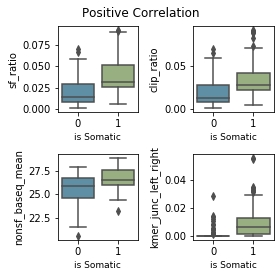

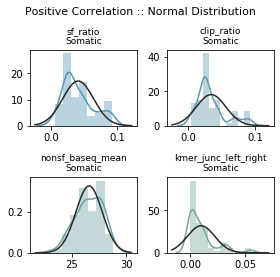

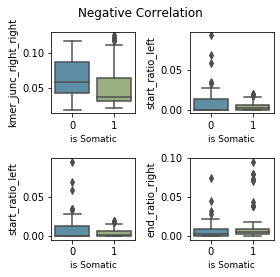

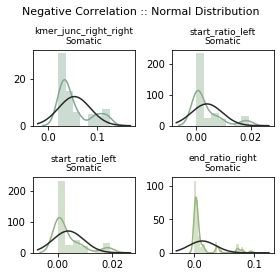

In [11]:
#after outlier removal 
plot_pos_neg_corr(new_df)

In [12]:
#dimensionality reduction and clustering
X = new_df[feats]
y = new_df['lab']
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2,n_iter=100000,
                      learning_rate=2e2,
                      random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))
# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))
# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 0.42 s
PCA took 0.00083 s
Truncated SVD took 0.0013 s


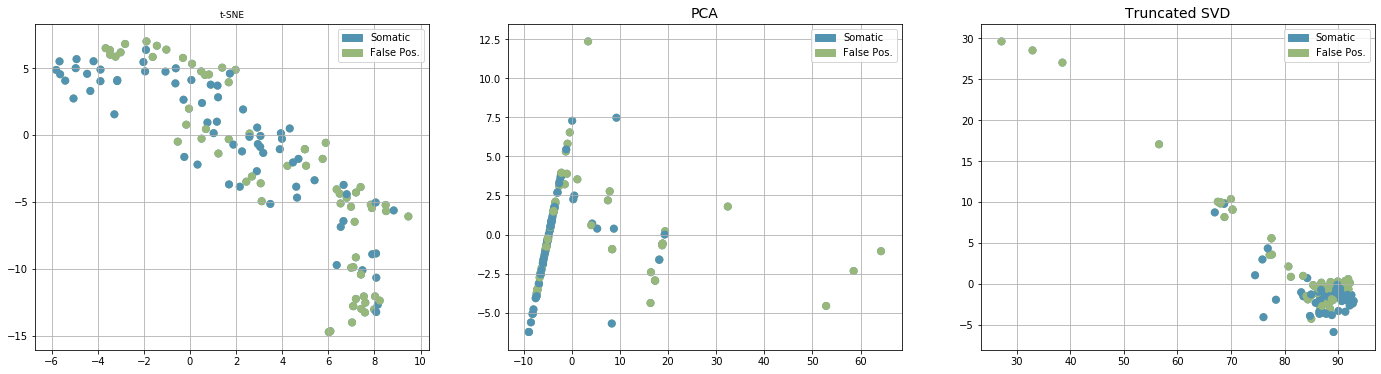

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
colr = ['#5293b1','#98b77a']
my_cmap = matplotlib.colors.ListedColormap(colr)
blue_patch = mpatches.Patch(color=colr[0], label='Somatic')
red_patch = mpatches.Patch(color=colr[1], label='False Pos.')
# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap=my_cmap, label='Somatic', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0],  X_reduced_tsne[:,1], c=(y == 1), cmap=my_cmap, label='False Pos.', linewidths=2)
ax1.set_title('t-SNE', fontsize=9)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])
# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap=my_cmap, label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap=my_cmap, label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])
# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap=my_cmap, label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap=my_cmap, label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])
plt.show()

In [14]:
# undersampling
## learning curves
## overfit => wide-gap in training score and cv score
## score is low for both => underfitt (high bias)
df,feats = load_training()
new_df = random_undersample(df)
report_class_counts(new_df)
drop_outliers_itr(new_df,outlier_feats)
report_class_counts(new_df)
X = new_df[feats]
y = new_df['lab']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Somatic 50.0 % of data
False Positive 50.0 % of data
Somatic: 68
False Positive: 68
Quartile 25: 0.03168812859202176 | Quartile 75: 0.06337855111371478
iqr: 0.03169042252169302
Cut Off: 0.04753563378253953
Lower: -0.015847505190517766
Upper: 0.1109141848962543
kmer_junc_right_right Outliers for Somatic: 6
Remaining samples:  126
------------------------------------------------------------
Quartile 25: 0.0 | Quartile 75: 0.007209177290445321
iqr: 0.007209177290445321
Cut Off: 0.010813765935667982
Lower: -0.010813765935667982
Upper: 0.0180229432261133
start_ratio_left Outliers for Somatic: 4
Remaining samples:  113
------------------------------------------------------------
Quartile 25: 0.0023269772863425482 | Quartile 75: 0.008333333333333333
iqr: 0.006006356046990785
Cut Off: 0.009009534070486179
Lower: -0.006682556784143631
Upper: 0.01734286740381951
end_ratio_right Outliers for Somatic: 7
Remaining samples:  102
------------------------------------------------------------
Quartile 2

Logistic Regression Cross Validation Score:  78.6%
Knears Neighbors Cross Validation Score 67.42%
Support Vector Classifier Cross Validation Score 74.22%
DecisionTree Classifier Cross Validation Score 81.5%


<module 'matplotlib.pyplot' from '/usr/lib/python3.7/site-packages/matplotlib/pyplot.py'>

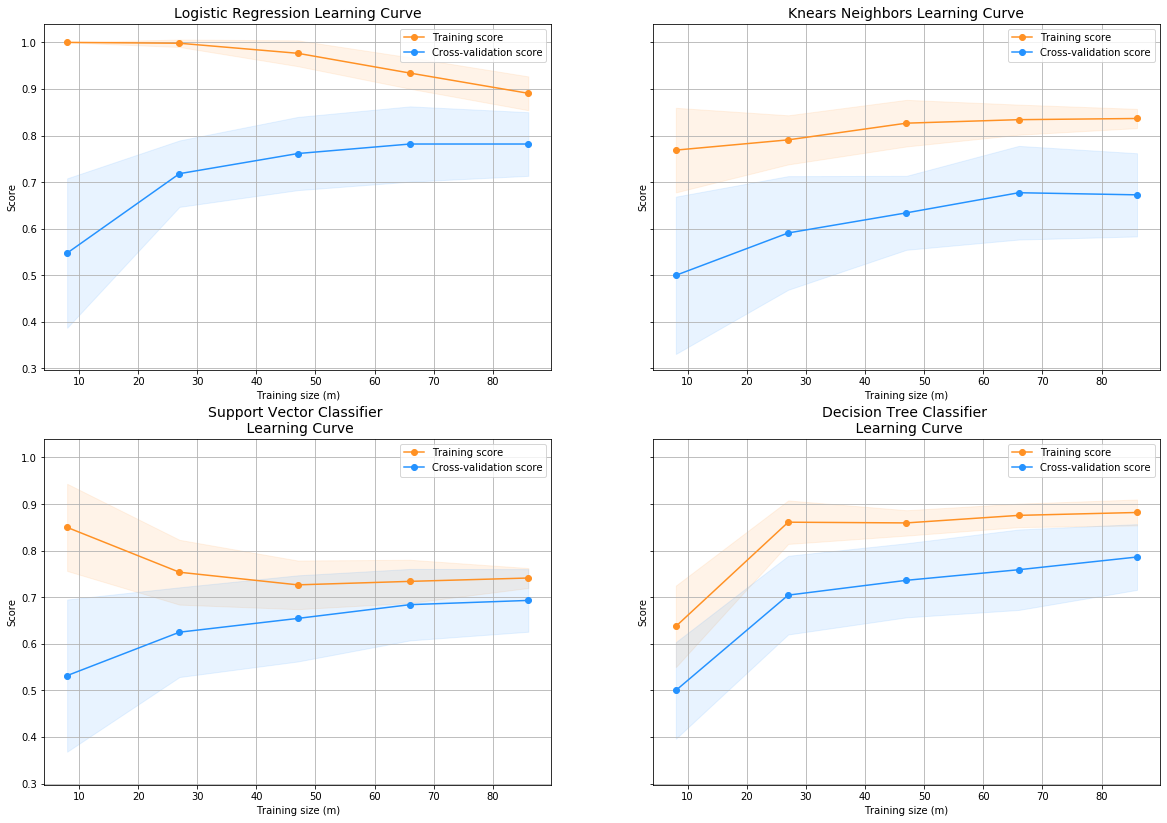

In [15]:
# grid search
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears_neighbors = grid_knears.best_estimator_
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')
knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')
svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')
tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [16]:
#undersample during cross validating
df,feats = load_training()
df = random_undersample(df)
undersample_X = df[feats]
undersample_y = df['lab']
#sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []
# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 22  23  24  25  26  28  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135] Test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 27 29
 30 31 32 33]
Train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  27  29  30  31  32  33  49  51  52  53  55  57  59  61
  62  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135] Test: [22 23 24

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,method="decision_function")
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,method="decision_function")
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)
def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(4,4))
    plt.title('ROC Curve', fontsize=11)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.legend(fontsize=8)
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()
y_pred = log_reg.predict(X_train)
# Overfitting Case
print('-' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('-' * 45)
# How it should look like
print('-' * 45)
print('Undersample during CV:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('-' * 45)

In [ ]:
#SMOTE
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []
log_reg_sm = LogisticRegression()
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=2,n_jobs=-1)
# Implementing SMOTE Technique 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority',n_jobs=8), rand_log_reg,) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
print('-' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('-' * 45)
labels = ['False Pos.', 'Somatic']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))
y_score = best_est.decision_function(original_Xtest)
average_precision = average_precision_score(original_ytest, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

fig,ax = plt.subplots(1,1,figsize=(5,5))
precision, recall, _ = precision_recall_curve(original_ytest, y_score)
ax.step(recall, precision, color='#5293b1',where='post')
ax.fill_between(recall, precision, step='post', alpha=0.8,color='#5293b1')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title('SMOTE Precision-Recall Curve\nAverage Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=9)
f.tight_layout()
f.savefig("../FIGURES/som.train.smote.precision-recall.png",dpi=500)
f.savefig("../FIGURES/som.train.smote.precision-recall.svg",dpi=500)

In [ ]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

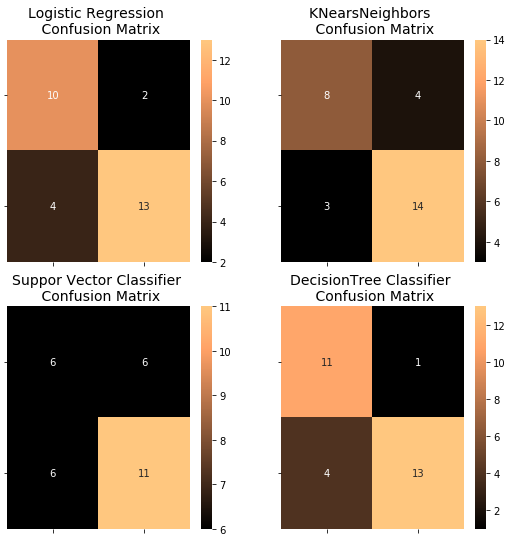

,Technique,Score
0,Random UnderSampling,0.793103
1,Oversampling (SMOTE),0.898213


In [24]:
from sklearn.metrics import confusion_matrix
# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)
# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)
fig, ax = plt.subplots(2, 2,figsize=(9,9))
sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)
plt.show()
# clockwise from top-left: TN, FN, TP, FP
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score
# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)
# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)
d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)
# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)
# Note how high is accuracy score it can be misleading! 
final_df

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 2)                

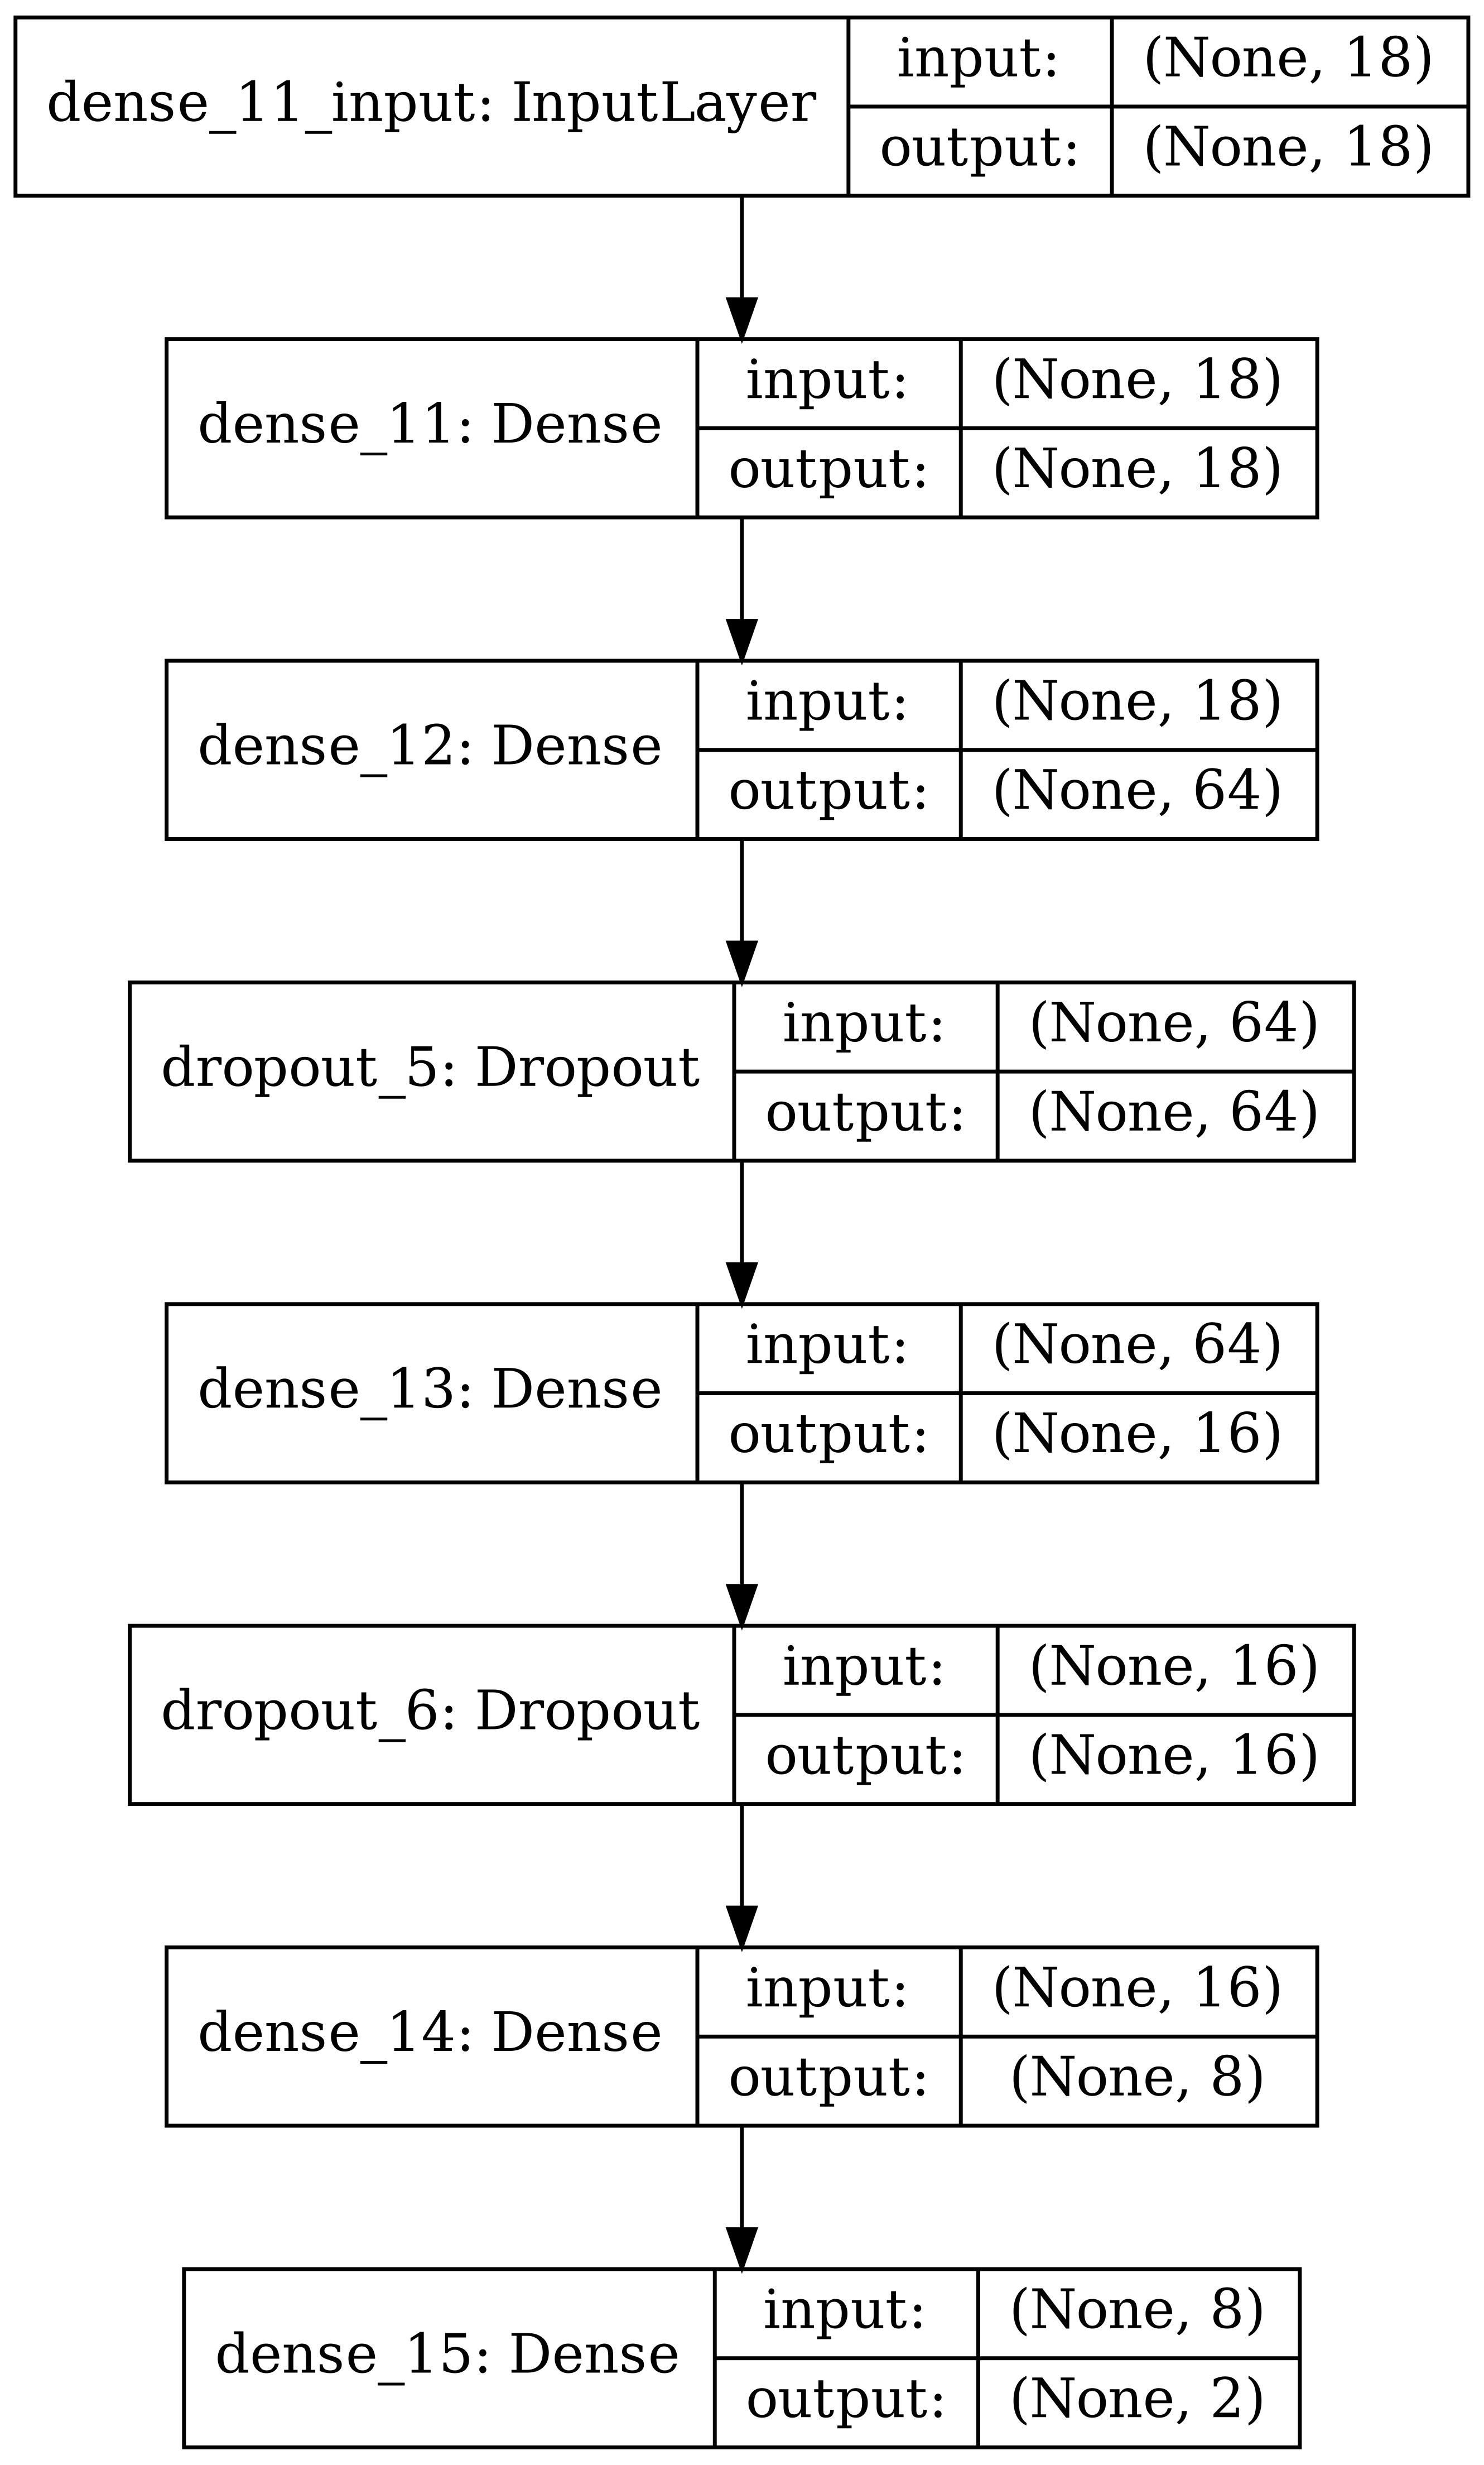

In [19]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.constraints import max_norm
from keras.metrics import categorical_crossentropy
from keras.utils import plot_model

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(16,activation='sigmoid'),
    Dropout(0.25),
    Dense(8,activation='relu'),
    Dense(2, activation='softmax')
])
undersample_model.summary()
plot_model(
    undersample_model, 
    to_file='../FIGURES/som.train.nn.model.png',
    dpi=500,
    show_shapes=True,
    expand_nested=True,
)

In [113]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=int(2.5e4), shuffle=True, verbose=0)
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)
import itertools

Confusion matrix, without normalization
[[1632  368]
 [   2   11]]
Normalized confusion matrix
[[0.816      0.184     ]
 [0.15384615 0.84615385]]


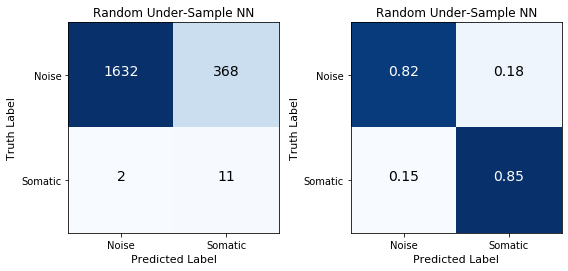

In [114]:
def plot_confusion_matrix(ax,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontsize=12)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.set_xticklabels(classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14,weight='medium'
               )
    ax.set_ylabel('Truth Label',fontsize=11)
    ax.set_xlabel('Predicted Label',fontsize=11)
###################################
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)

labels = ['Noise', 'Somatic']

f,ax = plt.subplots(1,2,figsize=(8,4))
plot_confusion_matrix(ax[0],undersample_cm, labels,normalize=False, title="Random Under-Sample NN", cmap='Blues')
plot_confusion_matrix(ax[1],undersample_cm, labels,normalize=True, title="Random Under-Sample NN", cmap='Blues')
f.tight_layout()
f.savefig("../FIGURES/som.train.undersample.cm.png",dpi=500)
f.savefig("../FIGURES/som.train.undersample.cm.svg",dpi=500)

In [115]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(16,activation='sigmoid'),
    Dropout(0.25),
    Dense(8,activation='relu'),
    Dense(2, activation='softmax')
])

oversample_model.summary()
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=200, epochs=500, shuffle=True, verbose=0)
print('>>>trained<<<')
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_25 (Dense)             (None, 2)                

Confusion matrix, without normalization
[[1906   94]
 [   4    9]]
Normalized confusion matrix
[[0.953      0.047     ]
 [0.30769231 0.69230769]]


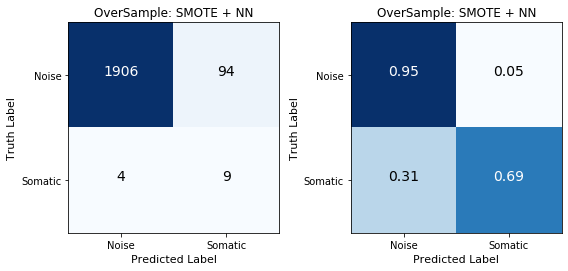

In [116]:
labels = ['Noise', 'Somatic']

f,ax = plt.subplots(1,2,figsize=(8,4))

plot_confusion_matrix(ax[0],oversample_smote, labels, title="OverSample: SMOTE + NN", cmap='Blues')
plot_confusion_matrix(ax[1],oversample_smote, labels,normalize=True, title="OverSample: SMOTE + NN", cmap='Blues')

f.tight_layout()
f.savefig('../FIGURES/som.train.smote.cm.png',dpi=500)
f.savefig('../FIGURES/som.train.smote.cm.svg',dpi=500)


In [117]:
df_test['pred']=oversample_fraud_predictions

In [118]:
df_test.to_csv("../RESULTS/chonk.trainingset.somatic.giabchr19.smotenn.preds.20190902.txt",
              index=False,sep='\t')

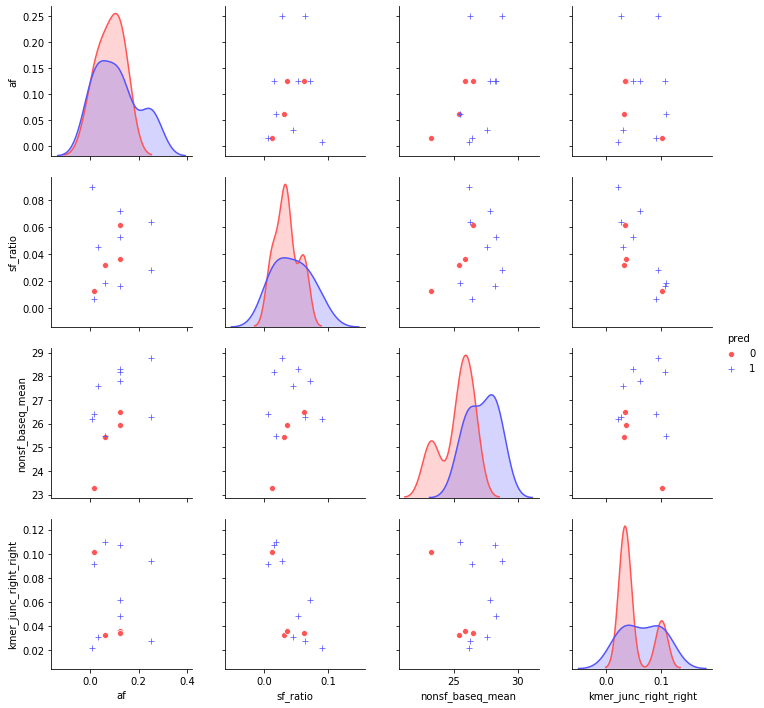

In [136]:
pos = ['af','sf_ratio','nonsf_baseq_mean','kmer_junc_right_right']

g = sns.pairplot(
    df_test.loc[df_test['lab']==1],
    hue='pred',
    vars=pos,
    palette='seismic_r',
    markers=['o','+'],
)

g.savefig("../FIGURES/som.train.smotenn.preds.feats.png",dpi=500)
g.savefig("../FIGURES/som.train.smotenn.preds.feats.svg",dpi=500)


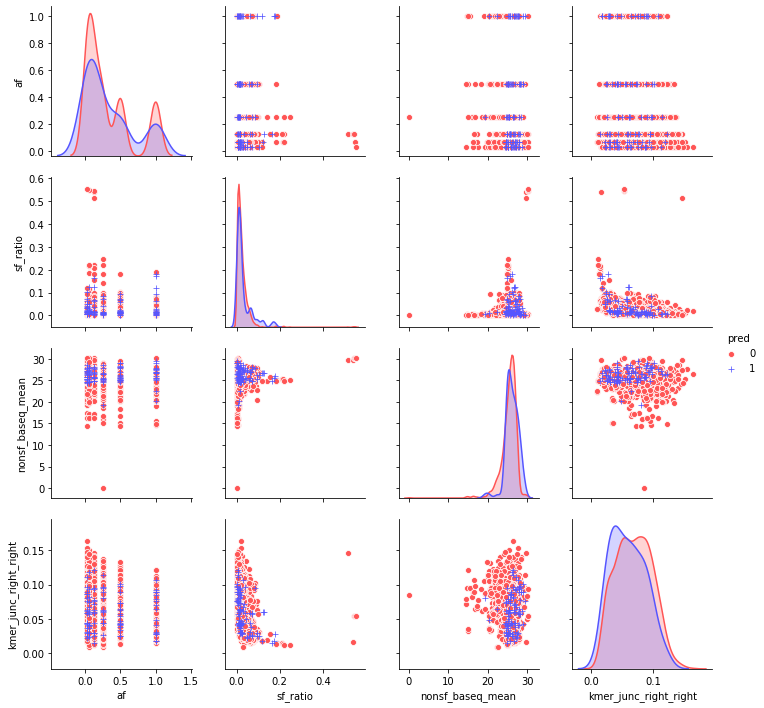

In [135]:
sns.pairplot(
    df_test.loc[df_test['lab']==0],
    hue='pred',
    vars=pos,
    palette='seismic_r',
    markers=['o','+'],
)